In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# Any results you write to the current directory are saved as output.

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
len(train_data)

159571

In [4]:
len(test_data)

153164

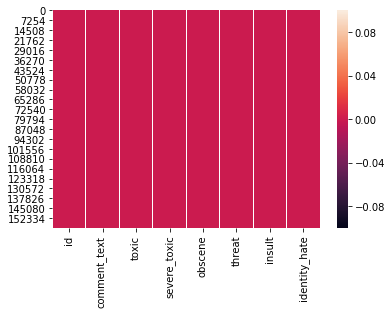

In [5]:
sns.heatmap(train_data.isna())

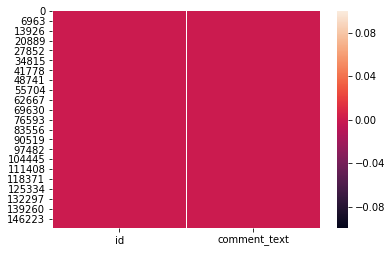

In [6]:
sns.heatmap(test_data.isna())

In [7]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [9]:
pd.options.display.max_colwidth=500
train_data.comment_text[0:5]

0                                                                                                                                                                                                                                              Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
1                                                                                                                                                                                                                                                                                                                                                                                                       D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2

In [10]:
train_data['text'] = train_data.comment_text.apply(lambda x: x.replace('\n', ' '))
test_data['text'] = test_data.comment_text.apply(lambda x: x.replace('\n', ' '))

In [11]:
cats = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_prepared_data = []

def format_text_spacy(text):
    return (text.text, {'cats': {cat: text[cat] for cat in cats}})
    
for i in range(0,len(train_data)):
    text = train_data.iloc[i]
    train_prepared_data.append(format_text_spacy(text))

In [12]:
train_prepared_data[0:3]

[("Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
  {'cats': {'identity_hate': 0,
    'insult': 0,
    'obscene': 0,
    'severe_toxic': 0,
    'threat': 0,
    'toxic': 0}}),
 ("D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
  {'cats': {'identity_hate': 0,
    'insult': 0,
    'obscene': 0,
    'severe_toxic': 0,
    'threat': 0,
    'toxic': 0}}),
 ("Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
  {'cats': {'identity_hate': 0,
    'insult': 0,
    'obscene': 0,
    'severe_toxic': 0,
    'threat': 0,
    'toxic': 0

In [14]:
import random
import spacy
import time
from spacy.util import minibatch, compounding

# nlp = spacy.load('en_core_web_lg')
nlp = spacy.load('en')
textcat = nlp.create_pipe('textcat')
nlp.add_pipe(textcat, last=True)
for cat in cats:
    textcat.add_label(cat)

In [15]:
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()
    print("Training the model...")
    # Use more iters
    for i in range(1):
        start_time = time.time()
        losses = {}
        # batch up the examples using spaCy's minibatch
        batches = minibatch(train_prepared_data, size=compounding(4., 32., 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses)
        print(f"--- {time.time() - start_time} seconds ---")
            

Training the model...
--- 1474.5783228874207 seconds ---


In [16]:
teste = nlp("Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.")

In [17]:
teste.cats

{'identity_hate': 0.0008797801565378904,
 'insult': 0.005440887529402971,
 'obscene': 0.002236374653875828,
 'severe_toxic': 0.0004073239688295871,
 'threat': 0.00011685056961141527,
 'toxic': 0.0275474451482296}

In [18]:
submission = test_data[['id']]
for cat in cats:
    submission[cat] = 0

for i in range(0,len(test_data)):
    cats_probas = nlp(train_data.iloc[i].text).cats
    for key in cats_probas.keys():
        submission.loc[i,key] = cats_probas[key]

/home/paulo/.virtualenvs/deep-learning/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 7 columns):
id               153164 non-null object
toxic            153164 non-null float64
severe_toxic     153164 non-null float64
obscene          153164 non-null float64
threat           153164 non-null float64
insult           153164 non-null float64
identity_hate    153164 non-null float64
dtypes: float64(6), object(1)
memory usage: 8.2+ MB


In [20]:
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.001532,0.000070,0.000430,0.000117,0.000472,0.000160
1,0000247867823ef7,0.109938,0.005640,0.025498,0.001759,0.014071,0.009853
2,00013b17ad220c46,0.027547,0.000407,0.002236,0.000117,0.005441,0.000880
3,00017563c3f7919a,0.000045,0.000045,0.000147,0.000045,0.000045,0.000045
4,00017695ad8997eb,0.155272,0.002127,0.019793,0.000148,0.028442,0.001442


In [21]:
submission.to_csv('submission.csv', index=False)